### Разбив пространство на различные частотные кластеры, возможно осуществлять классификацию новых треков, и затем тестировать элементы массива относительно каждого из них.
### Используем кластеризацию, чтобы сгруппировать треки, которые ведут себя одинаково. Кластеризация предваряет классификацию новых треков.
### Применяется техника обучения без учителя, поскольку отсутствуют признаки для обучения модели. Для расширения данных, необходимых для обучения, возможно использование генератора данных.
### В качестве метки класса можно принять номер кластера.
### Треки могут быть коллинеарными. Предусматриваем алгоритм установления их коллинеарности.
### Исследуем и нормализуем данные.Примем допущение, что любая точка данных, которая лежит ниже определенной нижней границы, и над верхней границей рассматривается как выброс. Удаляем выбросы в данных.
### Для кластеризации треков используем модель K-Means. Модель классифицирует новые треки по меткам кластеров.

In [1]:
# Импорт библиотек
import math
import h5py
import numpy as np
import pandas as pd
import sys
import os
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
from sklearn.cluster import KMeans
from matplotlib.collections import LineCollection
from sklearn import cluster, covariance, manifold

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
# read HDF5 files
with h5py.File('./data_tracks.hdf5', 'r') as hdf:
    lst = list(hdf.keys())
    print('list of statistics in this file: \n', lst)
    data = hdf.get('statistics')
    tracks = np.array(data)
    print('Shape of tracks: \n', tracks.shape)

list of statistics in this file: 
 ['statistics']
Shape of tracks: 
 (2278, 2386, 96)


### Исследование данных

In [4]:
# текущий тип элементов массива
tracks.dtype

dtype('<f4')

In [5]:
# количество осей массива
# tracks.ndim

In [6]:
# количество элементов по каждой оси
# tracks.shape

In [7]:
# число элементов массива
# tracks.size

In [8]:
# объем элемента массива в байтах
# tracks.itemsize

In [9]:
# изменение типа элементов массива
tracks.dtype = np.float32()

In [10]:
tracks.dtype

dtype('float32')

In [11]:
# число элементов массива нового типа
tracks.size

521789568

In [12]:
# объем элемента нового типа в байтах
# tracks.itemsize

In [13]:
# объем массива нового типа в байтах
# tracks.size * tracks.itemsize

In [14]:
# максимальное значение массива
tracks.max()

460932.34

In [15]:
# возвращает индекс максимального элемента в массиве
ind = np.unravel_index(np.argmax(tracks), tracks.shape)
print(ind)

(1913, 365, 6)


In [16]:
tracks[1913][365][6]

460932.34

<function matplotlib.pyplot.show(close=None, block=None)>

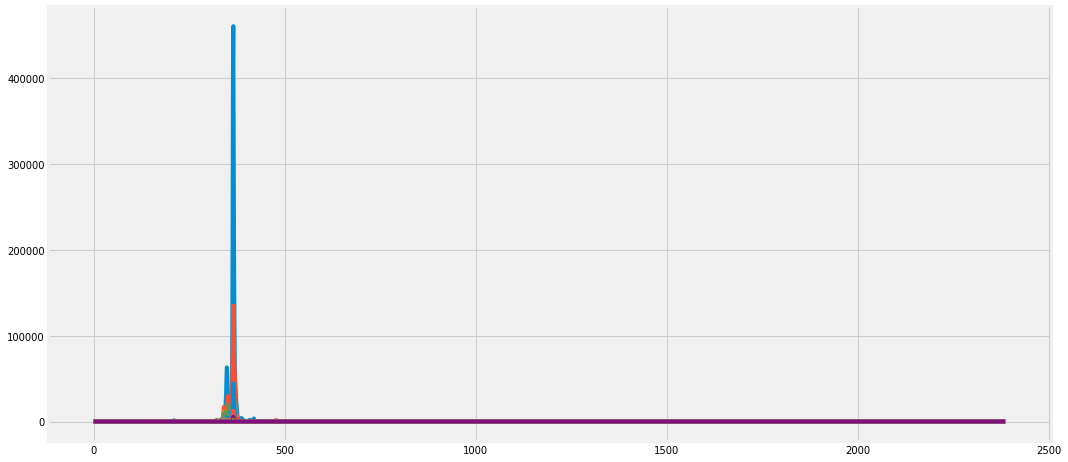

In [17]:
# график элемента массива в котором содержится максимальное значение
plt.figure(figsize = (16,8))
x = tracks[1913]
plt.plot(x)
plt.show

In [18]:
# минимальное значение массива
# tracks.min()

In [19]:
# среднее значение массива
tracks.mean()

7.1596785

In [20]:
# сумма элементов массива
# tracks.sum()

In [21]:
# среднеквадратичное отклонение значений элементов массива
tracks.std()

258.48553

In [22]:
# дисперсия
tracks.var()

66814.77

In [23]:
len(tracks.var(axis = 1))

2278

In [24]:
# медиана массива
np.median(tracks)

1.0087802

### Представления массива

In [25]:
# текущее представление массива
tracks

array([[[ 0.867584  ,  5.635525  ,  2.5787995 , ...,  0.8706721 ,
          0.68589914,  0.8776981 ],
        [ 1.4037471 , 19.115522  ,  5.16586   , ...,  0.9482794 ,
          0.94062   ,  0.98139787],
        [ 1.8050686 , 15.184977  ,  2.6675718 , ...,  0.7264305 ,
          0.77372444,  1.059285  ],
        ...,
        [ 0.92421615,  0.37927502,  0.75392497, ...,  0.7326072 ,
          0.78518754,  0.79141325],
        [ 0.9424971 ,  0.37329528,  0.66355497, ...,  0.7485685 ,
          0.6680854 ,  0.8393582 ],
        [ 1.9094379 ,  1.1741309 ,  1.4443483 , ...,  1.1425848 ,
          0.90442175,  1.19284   ]],

       [[ 1.0074121 ,  4.709533  ,  3.1523523 , ...,  0.9205721 ,
          0.93771636,  1.0677071 ],
        [ 1.8801966 , 16.365469  , 10.674385  , ...,  0.99993265,
          0.9004788 ,  0.7697731 ],
        [ 1.7967896 , 13.110364  ,  7.3786254 , ...,  0.79055804,
          1.042575  ,  1.024588  ],
        ...,
        [ 0.868971  ,  0.17583854,  0.09459264, ...,  

In [26]:
tracks.shape

(2278, 2386, 96)

In [27]:
# представление заданного массива в виде одномерного массива
tracks_1 = tracks.reshape(2278 * 2386 * 96)
tracks_1

array([0.867584 , 5.635525 , 2.5787995, ..., 1.3951364, 1.682604 ,
       2.1556501], dtype=float32)

In [28]:
tracks_1.shape

(521789568,)

In [29]:
# представление заданного массива в виде двумерного массива
tracks_2 = tracks.reshape(5435308, 96)
tracks_2

array([[ 0.867584  ,  5.635525  ,  2.5787995 , ...,  0.8706721 ,
         0.68589914,  0.8776981 ],
       [ 1.4037471 , 19.115522  ,  5.16586   , ...,  0.9482794 ,
         0.94062   ,  0.98139787],
       [ 1.8050686 , 15.184977  ,  2.6675718 , ...,  0.7264305 ,
         0.77372444,  1.059285  ],
       ...,
       [ 8.277474  ,  9.192697  ,  3.82261   , ...,  0.6952238 ,
         1.0069684 ,  0.9384058 ],
       [ 9.152346  , 10.507482  ,  4.6044683 , ...,  1.4006258 ,
         1.4775894 ,  1.2959621 ],
       [ 7.0055523 ,  8.014813  ,  3.8131993 , ...,  1.3951364 ,
         1.682604  ,  2.1556501 ]], dtype=float32)

In [30]:
tracks_2.shape

(5435308, 96)

In [31]:
len(tracks_2)

5435308

In [32]:
# возвращает значения меньше которых соответственно 5% и 95% всех значений массива
np.percentile(tracks_2, q = [5, 95])

array([0.35012377, 3.43479053])

In [33]:
# np.percentile(tracks_2, q = [5, 95], axis = 0)

In [34]:
# np.percentile(tracks_2, q = [5, 95], axis = 1)

In [35]:
# plt.figure(figsize = (16,10))
# x = tracks_2
# plt.plot(x)
# plt.show

### Нормализация данных и удаление выбросов

In [36]:
# нормализация данных
from sklearn import preprocessing
import numpy as np
x = preprocessing.normalize(tracks_2)
print(x)

[[0.0694866  0.45136094 0.20654142 ... 0.06973394 0.05493509 0.07029667]
 [0.06251634 0.85131603 0.23006327 ... 0.04223193 0.04189082 0.04370688]
 [0.09900888 0.83290327 0.1463176  ... 0.03984506 0.04243916 0.05810229]
 ...
 [0.4415205  0.49033844 0.20389801 ... 0.03708324 0.05371169 0.05005457]
 [0.41699436 0.47873634 0.20978637 ... 0.06381458 0.06732115 0.05904594]
 [0.3065705  0.35073686 0.1668697  ... 0.06105267 0.07363256 0.09433357]]


In [37]:
# np.set_printoptions(threshold = sys.maxsize)
# print(x)

In [38]:
# возвращает значения меньше которых соответственно 5% и 95% всех нормализованных значений массива
np.percentile(x, q = [5, 95], keepdims = True )

array([[[0.01876068]],

       [[0.16884653]]])

c:\users\expli\appdata\local\programs\python\python38\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

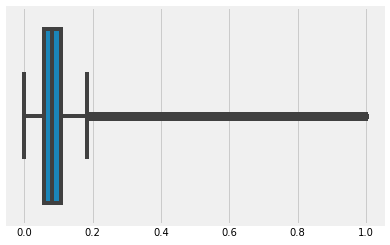

In [39]:
# Любая точка данных, которая лежит ниже нижней границы, и над верхней границей рассматривается как выброс
import seaborn as sns
sns.boxplot(x)

In [40]:
# заменим в массиве все выбросы нулевыми значениями
x1 = x.copy()
x1[x1 >= 0.4] = 0

In [41]:
len(tracks_1)

521789568

In [42]:
# количество удаленных выбросов в массиве 
print(len(tracks_1) - np.count_nonzero(x1))

1295998


### Кластеризация данных Модель K-Means

In [43]:
# Инициализация модели
from sklearn.cluster import KMeans
model = KMeans(n_clusters = 8, init = 'k-means++', n_init = 10, max_iter = 300, tol = 0.0001, verbose = 0, random_state = 42,
               copy_x = True, algorithm = 'auto')

In [44]:
# Подгонка модели по данным из представления 2D
model.fit(x1)

KMeans(random_state=42)

In [45]:
# метка точки (к какому кластеру принадлежит каждый трек)
model.labels_

array([6, 4, 4, ..., 4, 4, 7])

In [46]:
model.labels_.shape

(5435308,)

In [47]:
# координаты центров кластеров
model.cluster_centers_

array([[0.05677005, 0.05828882, 0.05655666, 0.06661506, 0.06366687,
        0.06358427, 0.0625995 , 0.07066858, 0.06575006, 0.08190217,
        0.08405691, 0.08660458, 0.08881576, 0.09010941, 0.09141244,
        0.0930267 , 0.09365719, 0.09462592, 0.09533266, 0.09565352,
        0.09615058, 0.09681489, 0.09748381, 0.09774325, 0.09581997,
        0.09076622, 0.09740796, 0.09865744, 0.09929119, 0.09950479,
        0.09988783, 0.09988935, 0.10005847, 0.10022365, 0.100516  ,
        0.10069577, 0.10066272, 0.10101653, 0.1010751 , 0.10119342,
        0.10123419, 0.09821343, 0.09688167, 0.09707785, 0.0971739 ,
        0.0972051 , 0.09734212, 0.097544  , 0.09756961, 0.097546  ,
        0.09752888, 0.09779456, 0.09784965, 0.0973326 , 0.09702066,
        0.09721512, 0.09722317, 0.0969937 , 0.09659087, 0.09667382,
        0.09687006, 0.09691519, 0.0969322 , 0.09696237, 0.09690851,
        0.09684932, 0.09659837, 0.09661178, 0.09673218, 0.09672824,
        0.09672293, 0.0966497 , 0.09644143, 0.09

In [48]:
model.cluster_centers_.shape

(8, 96)

<function matplotlib.pyplot.show(close=None, block=None)>

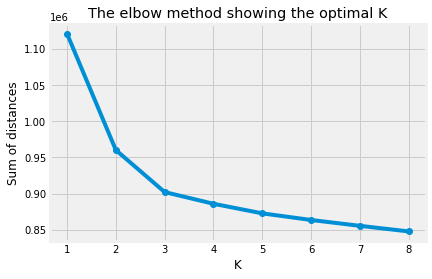

In [49]:
# определение количества кластеров
K = range(1, 9)
models = [KMeans(n_clusters = k, random_state = 42).fit(x1) for k in K]
dist = [model.inertia_ for model in models]

plt.plot(K, dist, marker = 'o')
plt.xlabel('K')
plt.ylabel('Sum of distances')
plt.title('The elbow method showing the optimal K')
plt.show

In [50]:
# исходя из графика, принимаем количество кластеров

In [55]:
# предсказание по новым трекам, метод predict
new_items = tracks_2*0.15
model.predict(new_items)

array([2, 2, 2, ..., 7, 7, 2])